# **Airbnb Feature Engineering Notebook**

## Objectives

* Have `Engineer Features` set up for the ML.  

## Inputs

* Use data cleaned for this process: `outputs/datasets/cleaned/TrainSetAnalysis` and `outputs/datasets/cleaned/TestSetAnalysis`. 

## Outputs

* Have a list of variables to engineer created. 

---

# Change working directory 

Have the working directory changed from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices/jupyter_notebooks'

Have the parent of the current directory set up as the new current directory.
* `os.path.dirname()` gets the parent directory;
* `os.chir()` defines the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Have the new current directory confirmed.

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices'

---

# Loading Cleaned Data

`TrainSetAnalysis`

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetAnalysisCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head()

,city,bedrooms,city_center_dist_km,metro_dist_km,daily_price,weekends
0,London,1,4.824,0.446,524.47,0
1,London,2,5.940,0.378,517.42,1
2,London,0,3.528,0.197,323.15,0
3,London,1,7.771,1.255,257.77,0
4,London,2,1.754,0.244,989.68,0


`TestSetAnalysis`

In [5]:
import pandas as pd
test_set_path = "outputs/datasets/cleaned/TestSetAnalysisCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head()

,city,bedrooms,city_center_dist_km,metro_dist_km,daily_price,weekends
0,London,3,2.174,0.320,2976.55,0
1,Amsterdam,2,3.154,0.602,870.57,1
2,London,1,8.187,1.269,554.11,0
3,London,1,1.493,0.359,494.60,1
4,London,1,1.363,0.294,422.63,0


---

# Data Exploration

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Feature Engineering 

* A custom function is being used in the feature engineering process of my analysis to deal with the data that needs to be tranformed to create our ML.

In [7]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'one_hot_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'one_hot_encoder':
        list_column_transformers = ["one_hot_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    elif analysis_type == 'one_hot_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_OneHotEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")

    # Collect original and transformed columns correctly
    transformed_columns = [f"{method}" for method in list_applied_transformers]
    unique_columns = [column] + transformed_columns

    # Debugging: Print all columns to check if they exist in df_feat_eng
    print(f"Unique columns for plotting: {unique_columns}")
    print(f"Available columns in df_feat_eng: {df_feat_eng.columns.tolist()}")

    # Iterate through unique columns and plot if they exist
    for col in unique_columns:
        if col in df_feat_eng.columns:
            print(f"Analyzing column: {col}")
            if analysis_type != 'ordinal_encoder':
                DiagnosticPlots_Numerical(df_feat_eng, col)
            else:
                if col == column:
                    DiagnosticPlots_Categories(df_feat_eng, col)
                else:
                    DiagnosticPlots_Numerical(df_feat_eng, col)
            print("\n")
        else:
            print(f"Column {col} not found in df_feat_eng. Skipping plotting.")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable, discrete=False):
    print(f"Generating plots for variable: {variable}, discrete: {discrete}")
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    if discrete:
        sns.histplot(data=df, x=variable, element="bars", ax=axes[0])
    else:
        sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
            f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OneHotEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OneHotEncoder(sparse=False)
        encoded_column = encoder.fit_transform(df_feat_eng[[column]])
        # Use get_feature_names_out if available, else fall back to get_feature_names
        try:
            encoded_df = pd.DataFrame(encoded_column, columns=encoder.get_feature_names_out([column]))
        except AttributeError:
            encoded_df = pd.DataFrame(encoded_column, columns=encoder.get_feature_names([column]))

        df_feat_eng = pd.concat([df_feat_eng.drop(columns=[column]), encoded_df], axis=1)
        list_methods_worked += encoded_df.columns.tolist()
    except Exception as e:
        print(f"Error occurred: {e}")

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(log_base=10, variables=[f"{column}_log_10"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

# Feature Engineering Spreadsheet Summary

A spreadsheet summary was used to make notes and list the transformes that will be used. `Clique here to check the spreadsheet`.

* ### One Hot Enconder 

1. Have variable(s) that will be transformed selected:

In [8]:
variables_engineering= ['city']
variables_engineering

['city']

2. Have a separate DataFrame created for the variable(s):

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

,city
0,London
1,London
2,London
3,London
4,London


3. Have engineering variable(s) created by applying the transformation(s):

* Variable Analyzed: city
* Applied transformation: ['city_Amsterdam', 'city_Barcelona', 'city_London'] 

Unique columns for plotting: ['city', 'city_Amsterdam', 'city_Barcelona', 'city_London']
Available columns in df_feat_eng: ['city_one_hot_encoder', 'city_Amsterdam', 'city_Barcelona', 'city_London']
Column city not found in df_feat_eng. Skipping plotting.
Analyzing column: city_Amsterdam
Generating plots for variable: city_Amsterdam, discrete: False


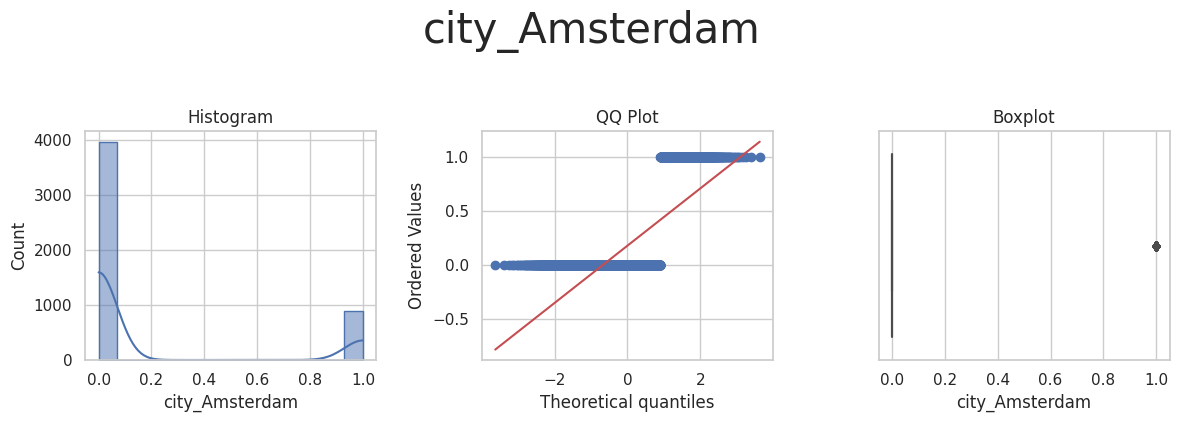



Analyzing column: city_Barcelona
Generating plots for variable: city_Barcelona, discrete: False


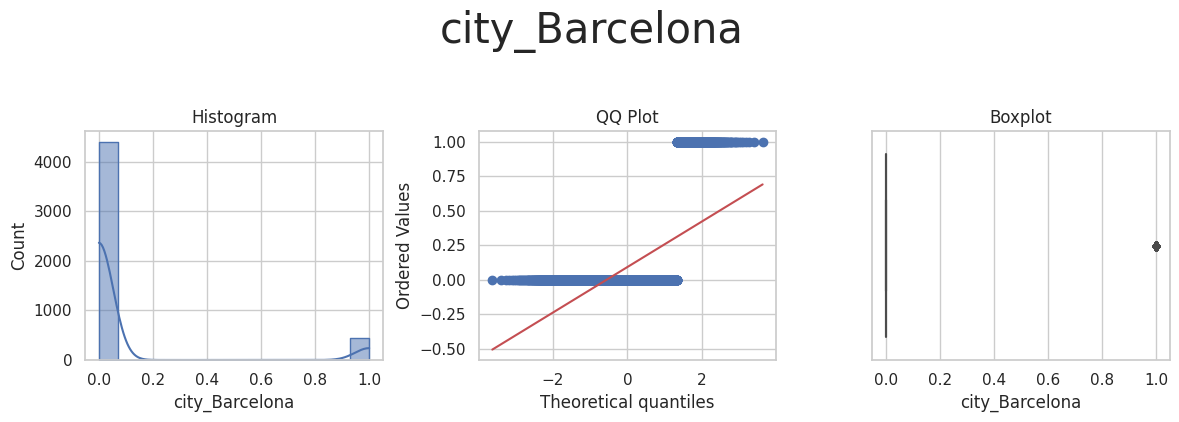



Analyzing column: city_London
Generating plots for variable: city_London, discrete: False


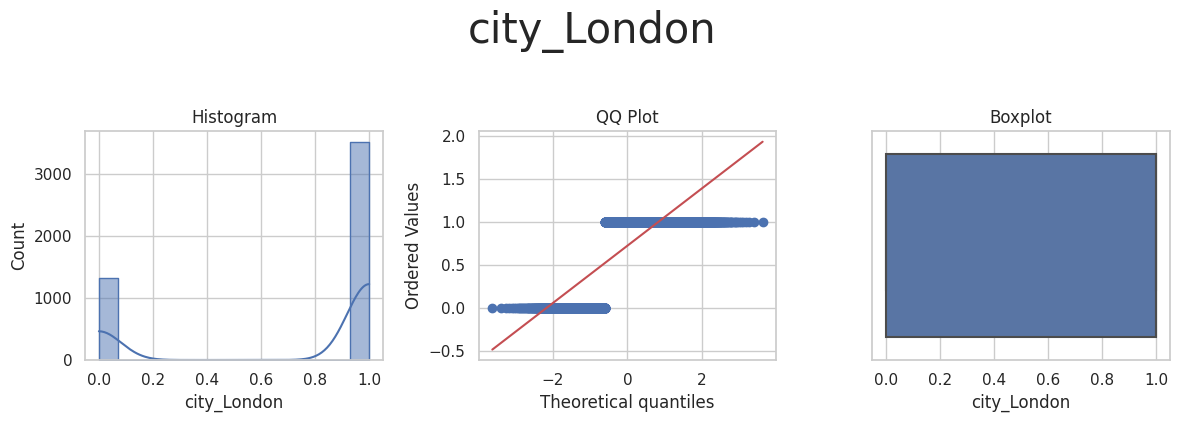

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='one_hot_encoder')

4. Have transformation applied to the `TrainSet` and `TestSet`:

In [11]:

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the TrainSet
train_encoded = encoder.fit_transform(TrainSet[variables_engineering])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names(variables_engineering))

# Drop the original categorical column and concatenate the new one-hot encoded columns
TrainSet = TrainSet.drop(columns=variables_engineering).reset_index(drop=True)
TrainSet = pd.concat([TrainSet, train_encoded_df], axis=1)

# Transform the TestSet
test_encoded = encoder.transform(TestSet[variables_engineering])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names(variables_engineering))

# Drop the original categorical column and concatenate the new one-hot encoded columns
TestSet = TestSet.drop(columns=variables_engineering).reset_index(drop=True)
TestSet = pd.concat([TestSet, test_encoded_df], axis=1)

# Add binary transformation for each city in TrainSet
TrainSet['is_Amsterdam'] = (TrainSet['city_Amsterdam'] > 0).astype(int)
TrainSet['is_Barcelona'] = (TrainSet['city_Barcelona'] > 0).astype(int)
TrainSet['is_London'] = (TrainSet['city_London'] > 0).astype(int)

# Add binary transformation for each city in TestSet
TestSet['is_Amsterdam'] = (TestSet['city_Amsterdam'] > 0).astype(int)
TestSet['is_Barcelona'] = (TestSet['city_Barcelona'] > 0).astype(int)
TestSet['is_London'] = (TestSet['city_London'] > 0).astype(int)

TrainSet = TrainSet.drop(columns=['city_Amsterdam', 'city_Barcelona', 'city_London'])
TestSet = TestSet.drop(columns=['city_Amsterdam', 'city_Barcelona', 'city_London'])

print("* One-Hot Encoding transformation done!")


* One-Hot Encoding transformation done!


In [12]:
print(TrainSet.head())
print(TestSet.head())

   bedrooms  city_center_dist_km  metro_dist_km  daily_price  weekends  \
0         1                4.824          0.446       524.47         0   
1         2                5.940          0.378       517.42         1   
2         0                3.528          0.197       323.15         0   
3         1                7.771          1.255       257.77         0   
4         2                1.754          0.244       989.68         0   

   is_Amsterdam  is_Barcelona  is_London  
0             0             0          1  
1             0             0          1  
2             0             0          1  
3             0             0          1  
4             0             0          1  
   bedrooms  city_center_dist_km  metro_dist_km  daily_price  weekends  \
0         3                2.174          0.320      2976.55         0   
1         2                3.154          0.602       870.57         1   
2         1                8.187          1.269       554.11         0   
3

* ### Numerical Transformation

**Numerical Transformation** was used to check variables for best distribution of data.

1. Have variable(s) selected:

In [13]:
variables_engineering = ['bedrooms', 'city_center_dist_km', 'metro_dist_km']
variables_engineering

['bedrooms', 'city_center_dist_km', 'metro_dist_km']

2. Have a separate DataFrame created for the variable(s):

In [14]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

,bedrooms,city_center_dist_km,metro_dist_km
0,1,4.824,0.446
1,2,5.940,0.378
2,0,3.528,0.197
3,1,7.771,1.255
4,2,1.754,0.244


3. Have engineering variable(s) created by applying the transformation(s):

* Variable Analyzed: bedrooms
* Applied transformation: ['bedrooms_power', 'bedrooms_yeo_johnson'] 

Unique columns for plotting: ['bedrooms', 'bedrooms_power', 'bedrooms_yeo_johnson']
Available columns in df_feat_eng: ['bedrooms', 'bedrooms_power', 'bedrooms_yeo_johnson']
Analyzing column: bedrooms
Generating plots for variable: bedrooms, discrete: False


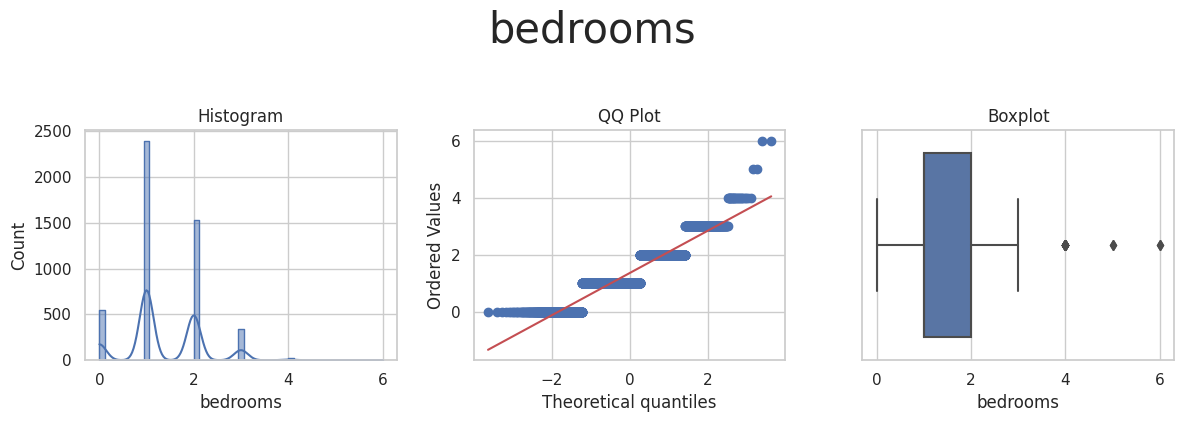



Analyzing column: bedrooms_power
Generating plots for variable: bedrooms_power, discrete: False


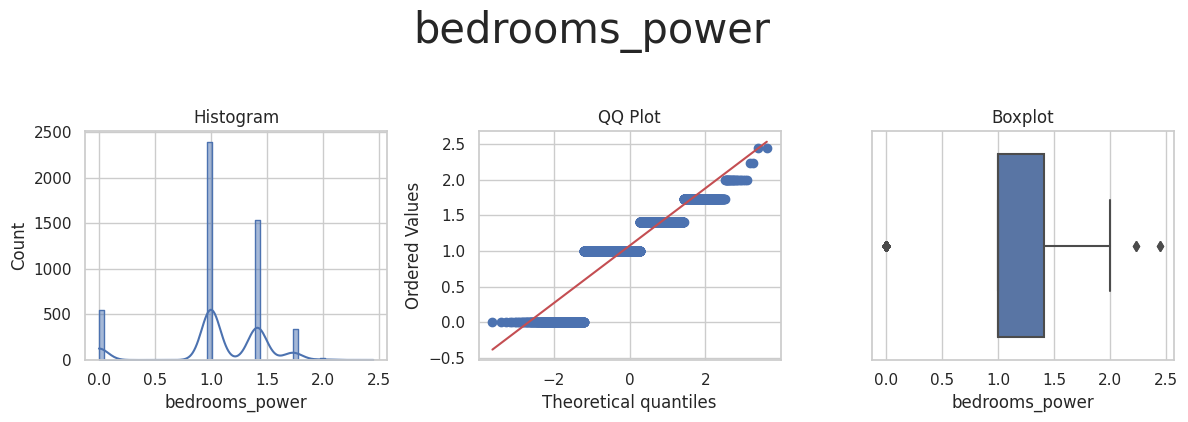



Analyzing column: bedrooms_yeo_johnson
Generating plots for variable: bedrooms_yeo_johnson, discrete: False


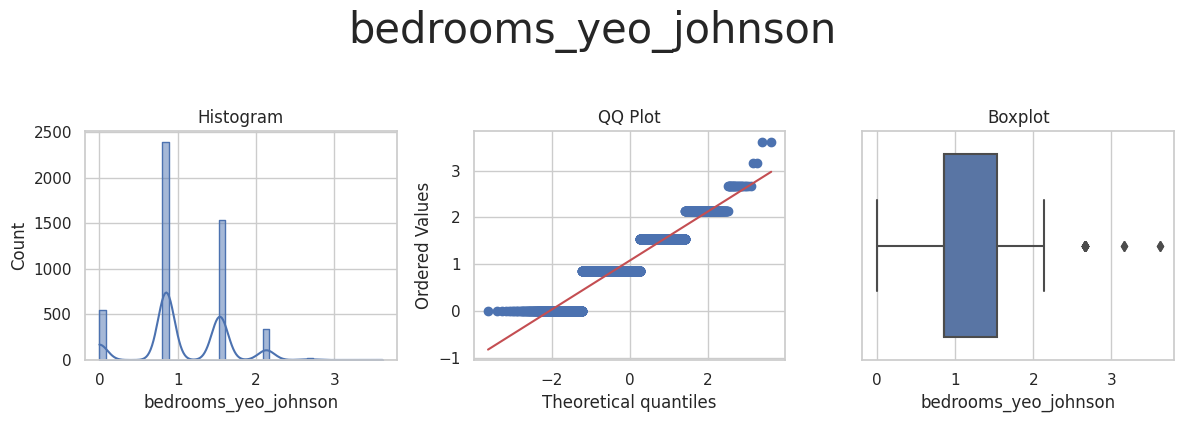



* Variable Analyzed: city_center_dist_km
* Applied transformation: ['city_center_dist_km_log_e', 'city_center_dist_km_reciprocal', 'city_center_dist_km_power', 'city_center_dist_km_box_cox', 'city_center_dist_km_yeo_johnson'] 

Unique columns for plotting: ['city_center_dist_km', 'city_center_dist_km_log_e', 'city_center_dist_km_reciprocal', 'city_center_dist_km_power', 'city_center_dist_km_box_cox', 'city_center_dist_km_yeo_johnson']
Available columns in df_feat_eng: ['bedrooms', 'bedrooms_power', 'bedrooms_yeo_johnson', 'city_center_dist_km', 'city_center_dist_km_log_e', 'city_center_dist_km_reciprocal', 'city_center_dist_km_power', 'city_center_dist_km_box_cox', 'city_center_dist_km_yeo_johnson']
Analyzing column: city_center_dist_km
Generating plots for variable: city_center_dist_km, discrete: False


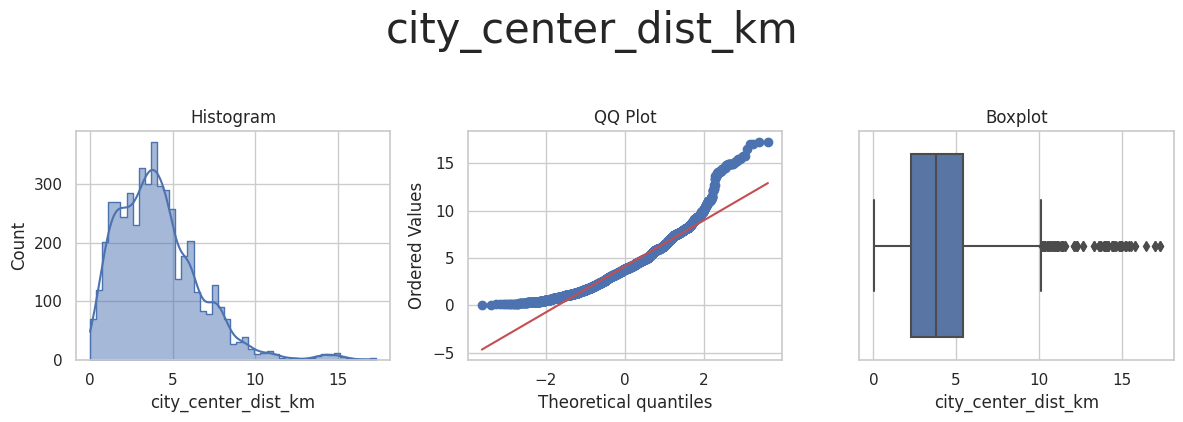



Analyzing column: city_center_dist_km_log_e
Generating plots for variable: city_center_dist_km_log_e, discrete: False


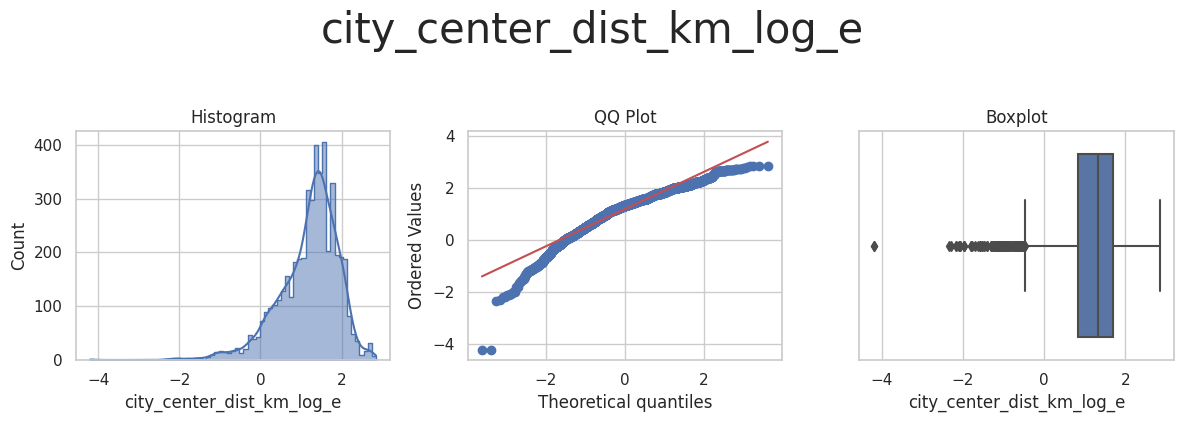



Analyzing column: city_center_dist_km_reciprocal
Generating plots for variable: city_center_dist_km_reciprocal, discrete: False


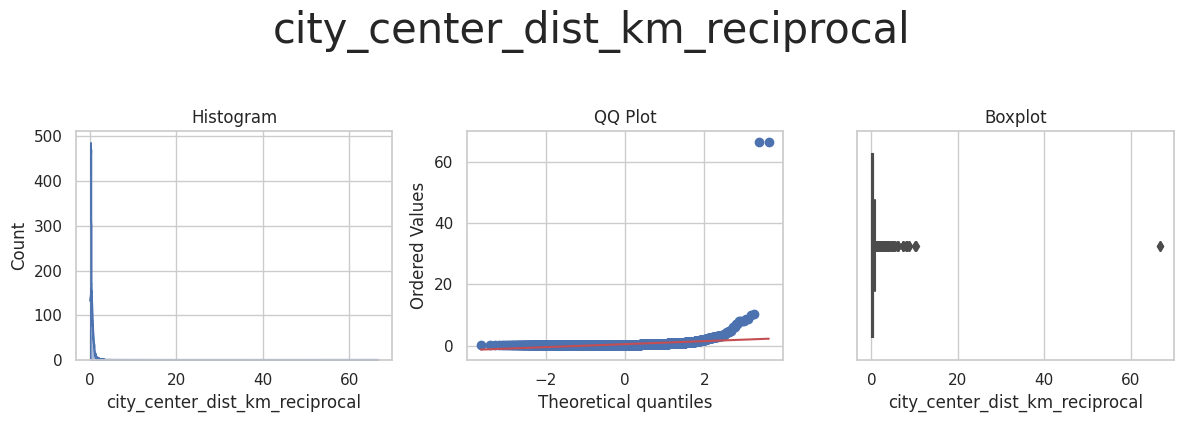



Analyzing column: city_center_dist_km_power
Generating plots for variable: city_center_dist_km_power, discrete: False


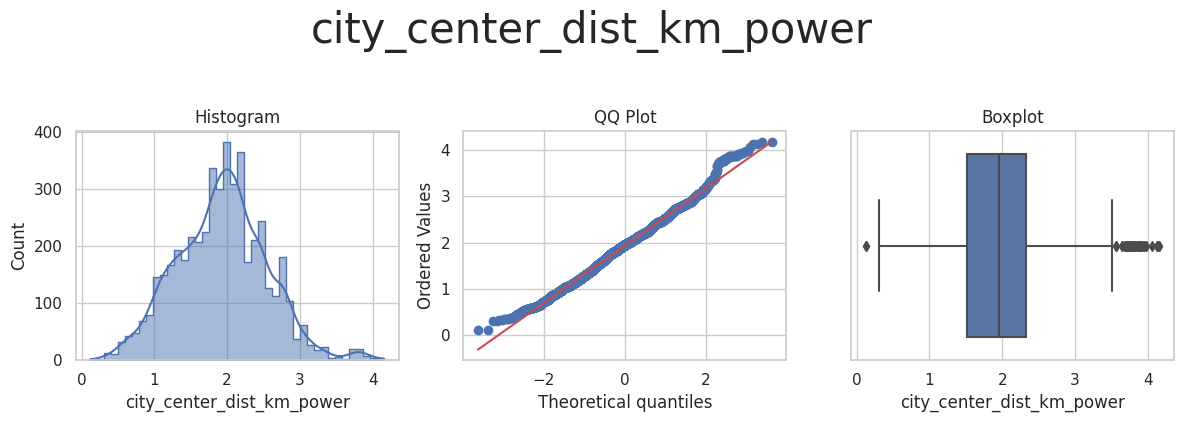



Analyzing column: city_center_dist_km_box_cox
Generating plots for variable: city_center_dist_km_box_cox, discrete: False


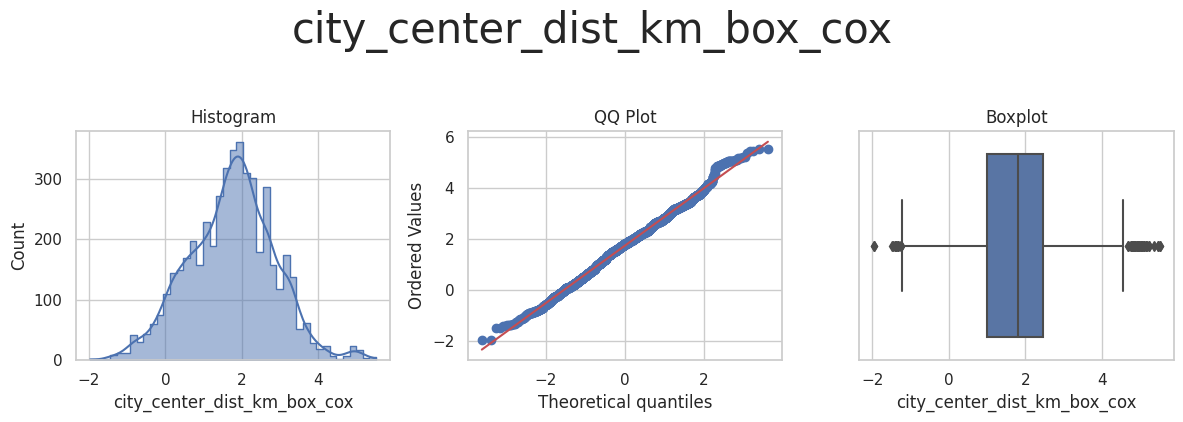



Analyzing column: city_center_dist_km_yeo_johnson
Generating plots for variable: city_center_dist_km_yeo_johnson, discrete: False


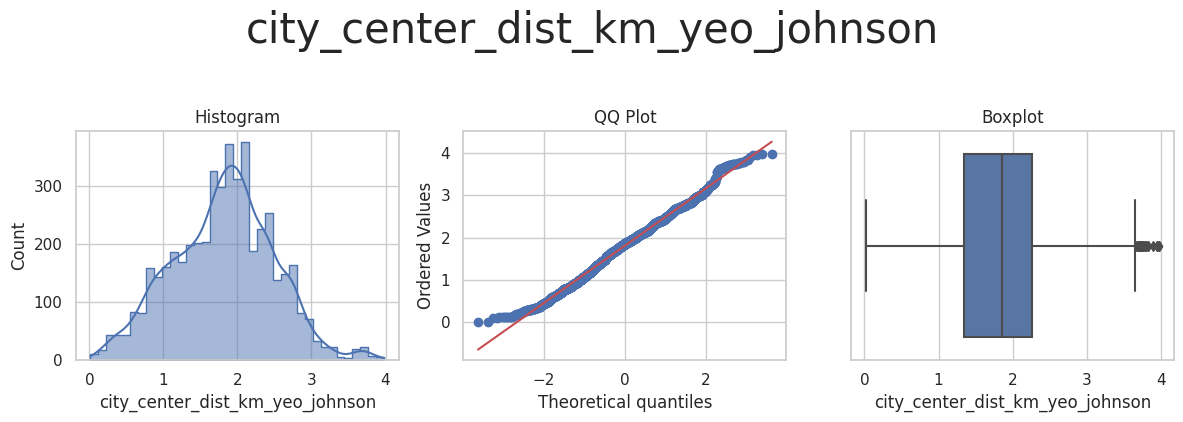



* Variable Analyzed: metro_dist_km
* Applied transformation: ['metro_dist_km_log_e', 'metro_dist_km_reciprocal', 'metro_dist_km_power', 'metro_dist_km_box_cox', 'metro_dist_km_yeo_johnson'] 

Unique columns for plotting: ['metro_dist_km', 'metro_dist_km_log_e', 'metro_dist_km_reciprocal', 'metro_dist_km_power', 'metro_dist_km_box_cox', 'metro_dist_km_yeo_johnson']
Available columns in df_feat_eng: ['bedrooms', 'bedrooms_power', 'bedrooms_yeo_johnson', 'city_center_dist_km', 'city_center_dist_km_log_e', 'city_center_dist_km_reciprocal', 'city_center_dist_km_power', 'city_center_dist_km_box_cox', 'city_center_dist_km_yeo_johnson', 'metro_dist_km', 'metro_dist_km_log_e', 'metro_dist_km_reciprocal', 'metro_dist_km_power', 'metro_dist_km_box_cox', 'metro_dist_km_yeo_johnson']
Analyzing column: metro_dist_km
Generating plots for variable: metro_dist_km, discrete: False


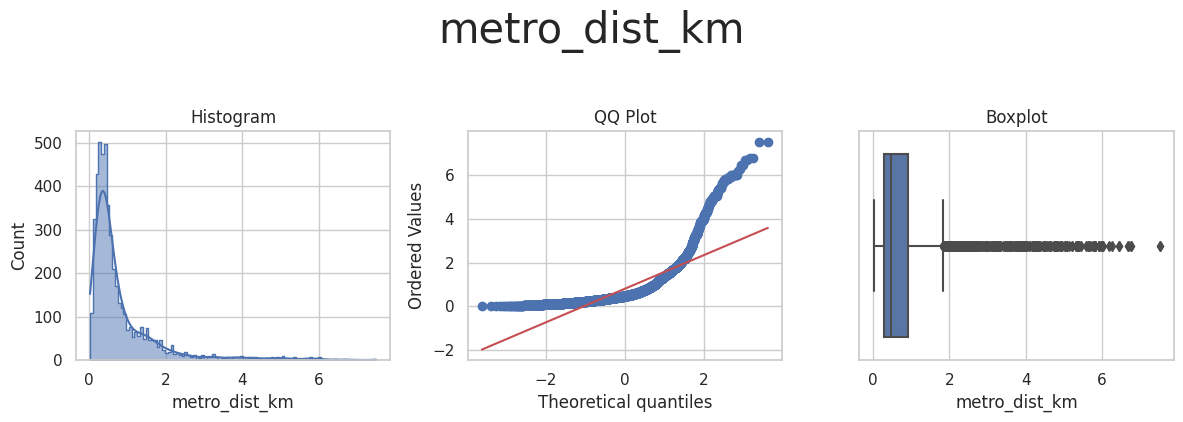



Analyzing column: metro_dist_km_log_e
Generating plots for variable: metro_dist_km_log_e, discrete: False


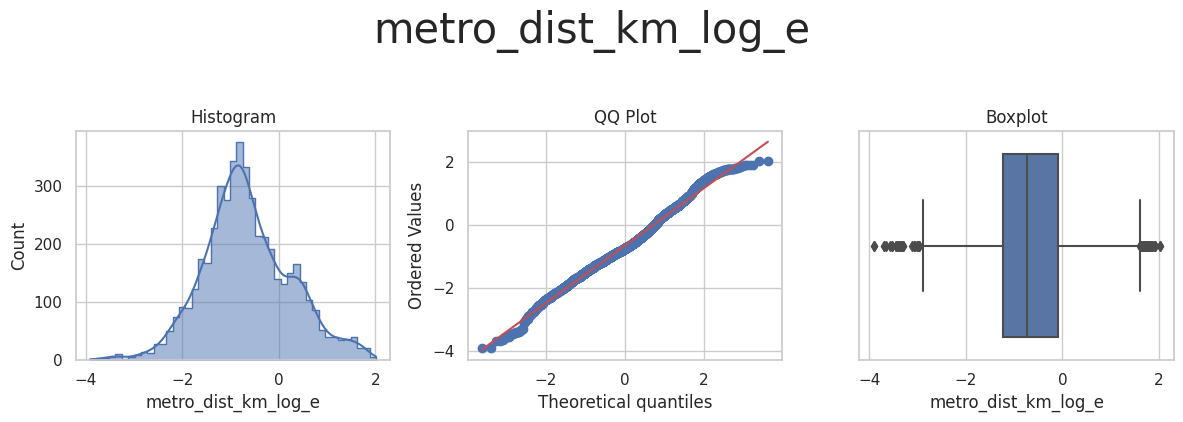



Analyzing column: metro_dist_km_reciprocal
Generating plots for variable: metro_dist_km_reciprocal, discrete: False


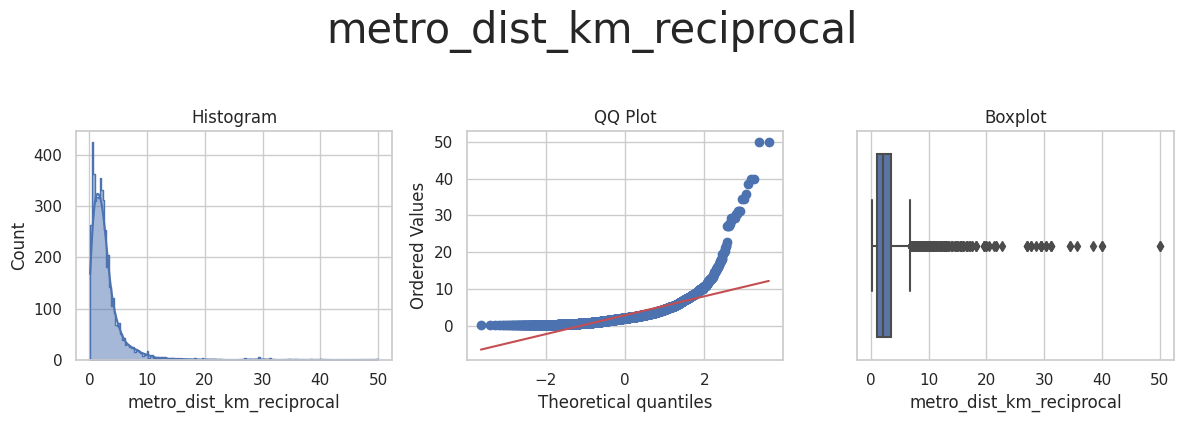



Analyzing column: metro_dist_km_power
Generating plots for variable: metro_dist_km_power, discrete: False


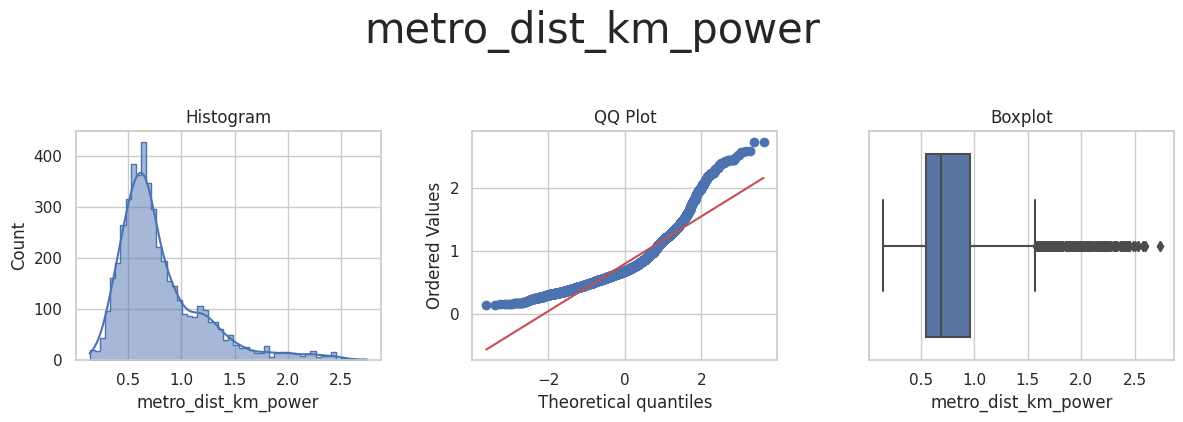



Analyzing column: metro_dist_km_box_cox
Generating plots for variable: metro_dist_km_box_cox, discrete: False


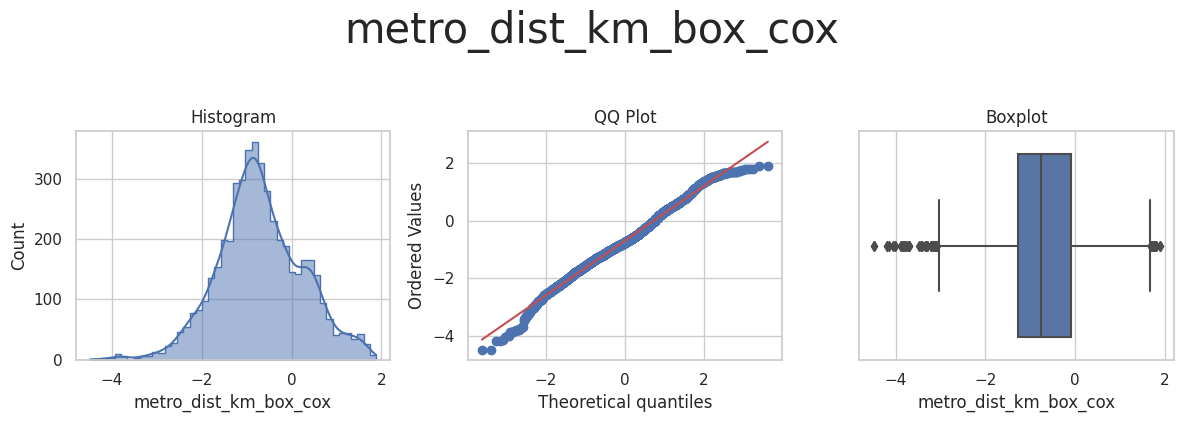



Analyzing column: metro_dist_km_yeo_johnson
Generating plots for variable: metro_dist_km_yeo_johnson, discrete: False


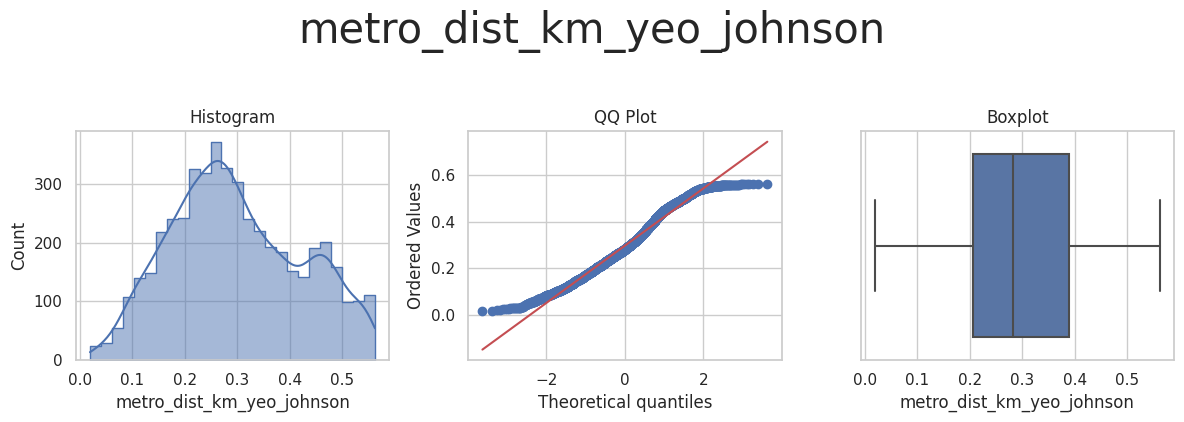

In [15]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

4. Have transformation applied to the `TrainSet` and `TestSet`:

`city_center_dist_km`

In [17]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
transformer = PowerTransformer(method='yeo-johnson')
TrainSet['city_center_dist_km'] = transformer.fit_transform(TrainSet[['city_center_dist_km']])
TestSet['city_center_dist_km'] = transformer.transform(TestSet[['city_center_dist_km']])

# Verify the transformation
print(TrainSet.head())
print(TestSet.head())

   bedrooms  city_center_dist_km  metro_dist_km  daily_price  weekends  \
0         1             0.455806          0.446       524.47         0   
1         2             0.838488          0.378       517.42         1   
2         0            -0.065774          0.197       323.15         0   
3         1             1.374887          1.255       257.77         0   
4         2            -1.005971          0.244       989.68         0   

   is_Amsterdam  is_Barcelona  is_London  
0             0             0          1  
1             0             0          1  
2             0             0          1  
3             0             0          1  
4             0             0          1  
   bedrooms  city_center_dist_km  metro_dist_km  daily_price  weekends  \
0         3            -0.748750          0.320      2976.55         0   
1         2            -0.236950          0.602       870.57         1   
2         1             1.484536          1.269       554.11         0   
3

`metro_dist_km`

In [ ]:
# Adding 1 here ensures no zero or negative values
TrainSet['metro_dist_km'] = TrainSet['metro_dist_km'] + 1
TestSet['metro_dist_km'] = TestSet['metro_dist_km'] + 1
# Initialize the PowerTransformer with Box-Cox method
transformer = PowerTransformer(method='box-cox')

# Apply Box-Cox transformation to metro_dist_km in TrainSet and TestSet
TrainSet['metro_dist_km'] = transformer.fit_transform(TrainSet[['metro_dist_km']])
TestSet['metro_dist_km'] = transformer.transform(TestSet[['metro_dist_km']])

# Verify the transformation
print(TrainSet.head())
print(TestSet.head())

# Smart Correlation 

1. Have a separeted DataFrame created:

In [19]:
df_engineering = TrainSet.copy()
df_engineering.head()

,bedrooms,city_center_dist_km,metro_dist_km,daily_price,weekends,is_Amsterdam,is_Barcelona,is_London
0,1,0.455806,-0.202474,524.47,0,0,0,1
1,2,0.838488,-0.417078,517.42,1,0,0,1
2,0,-0.065774,-1.157915,323.15,0,0,0,1
3,1,1.374887,1.120424,257.77,0,0,0,1
4,2,-1.005971,-0.936986,989.68,0,0,0,1


2. Have engineered variable(s) created to check the correlation:

In [20]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'is_Amsterdam', 'is_London'}]

`In my analysis I won't apply the smart correlation since I need these variables (**is_Amsterdam** and **is_London**) to create my ML and they were transformed not to mislead the results of my analysis.` 

---

# Conclusion 